# CNN Training

Target of this code is to train a CNN network to classify images of a digital readout to the digits 0 to 9. Additionally a category "NaN" is introduced, to mark images that are not amibiguous.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [1]:
########### Basic Parameters for Running: ################################
    
TFliteNamingAndVersion = "dig1210s1"   # Used for tflite Filename
Training_Percentage = 0.0              # 0.0 = Use all Images for Training
Epoch_Anz = 500

##########################################################################


import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import os
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import History 
from tensorflow.keras.utils import to_categorical
from PIL import Image 
from pathlib import Path

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

### Load training data
* The data is expected in the "Input_dir"
* Inside subdirectories are expected from -1, 0, 1, ... 9 in which the pictures are sorted according to their values (=category)
* Picture size must be 20x32 with 3 color channels (RGB)
* The filename can be arbitrary

* The images are stored in the x_data[]
* The expected category for each image in the corresponding y_data[]

* The last step is a shuffle (from sklearn.utils) and split the data into training and validation data

In [2]:
Input_dir='ziffer_sortiert_resize'

files = glob.glob(Input_dir + '/*.jpg')
x_data = []
y_data = []

for aktfile in files:
    base = os.path.basename(aktfile)
    target = base[0:1]
    if target == "N":
        category = 10                # NaN does not work --> convert to 10
    else:
        category = int(target)
    test_image = Image.open(aktfile)
    test_image = np.array(test_image, dtype="float32")
    x_data.append(test_image)
    y_data.append(np.array([category]))

x_data = np.array(x_data)
y_data = np.array(y_data)
y_data = to_categorical(y_data, 11)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)

if (Training_Percentage > 0):
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)
else:
    X_train = x_data
    y_train = y_data

(1491, 32, 20, 3)
(1491, 11)


### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (32, 20, 3)
* Number of output layers: 11
* As loss function "categorical_crossentropy" is choosen, as it is a categories task

In [3]:
model = Sequential()
model.add(BatchNormalization(input_shape=(32,20,3)))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(512,activation="relu"))
model.add(Dense(11, activation = "softmax"))
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 32, 20, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 20, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 10, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 5, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 2, 64)          0

# Training
The input pictures are randomly scattered for brightness, pixel shift variations and rotation angle. This is implemented with a ImageDataGenerator.


In [4]:
Batch_Size = 4
Shift_Range = 1
Brightness_Range = 0.3
Rotation_Angle = 10
ZoomRange = 0.4

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], 
                             height_shift_range=[-Shift_Range,Shift_Range],
                             brightness_range=[1-Brightness_Range,1+Brightness_Range],
                             zoom_range=[1-ZoomRange, 1+ZoomRange],
                             rotation_range=Rotation_Angle)

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit(train_iterator, epochs = Epoch_Anz)



Epoch 1/500
373/373 [==============================] - 10s 14ms/step - loss: 2.1255 - accuracy: 0.3478
Epoch 2/500
373/373 [==============================] - 5s 14ms/step - loss: 1.2215 - accuracy: 0.6063
Epoch 3/500
373/373 [==============================] - 5s 13ms/step - loss: 0.7984 - accuracy: 0.7400
Epoch 4/500
373/373 [==============================] - 5s 13ms/step - loss: 0.6838 - accuracy: 0.7921
Epoch 5/500
373/373 [==============================] - 5s 14ms/step - loss: 0.5583 - accuracy: 0.8132
Epoch 6/500
373/373 [==============================] - 5s 15ms/step - loss: 0.4881 - accuracy: 0.8608
Epoch 7/500
373/373 [==============================] - 5s 13ms/step - loss: 0.4156 - accuracy: 0.8838
Epoch 8/500
373/373 [==============================] - 5s 13ms/step - loss: 0.4423 - accuracy: 0.8768
Epoch 9/500
373/373 [==============================] - 5s 12ms/step - loss: 0.3625 - accuracy: 0.8676
Epoch 10/500
373/373 [==============================] - 5s 12ms/step - loss: 0.34

373/373 [==============================] - 5s 14ms/step - loss: 0.0666 - accuracy: 0.9819
Epoch 79/500
373/373 [==============================] - 5s 13ms/step - loss: 0.0931 - accuracy: 0.9733
Epoch 80/500
373/373 [==============================] - 5s 13ms/step - loss: 0.1030 - accuracy: 0.9681
Epoch 81/500
373/373 [==============================] - 5s 13ms/step - loss: 0.0349 - accuracy: 0.9871
Epoch 82/500
373/373 [==============================] - 5s 13ms/step - loss: 0.0790 - accuracy: 0.9718 0s - loss:
Epoch 83/500
373/373 [==============================] - 5s 14ms/step - loss: 0.0640 - accuracy: 0.9794 0s - loss:
Epoch 84/500
373/373 [==============================] - 5s 14ms/step - loss: 0.0423 - accuracy: 0.9783
Epoch 85/500
373/373 [==============================] - 5s 14ms/step - loss: 0.0506 - accuracy: 0.9817
Epoch 86/500
373/373 [==============================] - 5s 14ms/step - loss: 0.0671 - accuracy: 0.9811
Epoch 87/500
373/373 [==============================] - 5s 14ms/

373/373 [==============================] - 5s 14ms/step - loss: 0.0504 - accuracy: 0.9813
Epoch 157/500
373/373 [==============================] - 5s 14ms/step - loss: 0.0886 - accuracy: 0.9738
Epoch 158/500
373/373 [==============================] - 5s 14ms/step - loss: 0.0388 - accuracy: 0.9915
Epoch 159/500
373/373 [==============================] - 5s 14ms/step - loss: 0.0280 - accuracy: 0.9972
Epoch 160/500
373/373 [==============================] - 5s 13ms/step - loss: 0.0369 - accuracy: 0.9886
Epoch 161/500
373/373 [==============================] - 5s 13ms/step - loss: 0.0258 - accuracy: 0.9921
Epoch 162/500
373/373 [==============================] - 5s 14ms/step - loss: 0.0237 - accuracy: 0.9934
Epoch 163/500
373/373 [==============================] - 5s 13ms/step - loss: 0.0376 - accuracy: 0.9907
Epoch 164/500
373/373 [==============================] - 5s 13ms/step - loss: 0.0501 - accuracy: 0.9896
Epoch 165/500
373/373 [==============================] - 5s 13ms/step - loss: 

373/373 [==============================] - 5s 12ms/step - loss: 0.0313 - accuracy: 0.9899
Epoch 235/500
373/373 [==============================] - 5s 12ms/step - loss: 0.0208 - accuracy: 0.9914
Epoch 236/500
373/373 [==============================] - 5s 13ms/step - loss: 0.0521 - accuracy: 0.9899
Epoch 237/500
373/373 [==============================] - 5s 13ms/step - loss: 0.0281 - accuracy: 0.9896
Epoch 238/500
373/373 [==============================] - 5s 13ms/step - loss: 0.0117 - accuracy: 0.9974
Epoch 239/500
373/373 [==============================] - 5s 13ms/step - loss: 0.0415 - accuracy: 0.9924
Epoch 240/500
373/373 [==============================] - 5s 12ms/step - loss: 0.0205 - accuracy: 0.9912
Epoch 241/500
373/373 [==============================] - 5s 13ms/step - loss: 0.0416 - accuracy: 0.9865
Epoch 242/500
373/373 [==============================] - 5s 13ms/step - loss: 0.0327 - accuracy: 0.9939
Epoch 243/500
373/373 [==============================] - 5s 13ms/step - loss: 

373/373 [==============================] - 5s 13ms/step - loss: 0.0159 - accuracy: 0.9955
Epoch 313/500
373/373 [==============================] - 5s 12ms/step - loss: 0.0967 - accuracy: 0.9866
Epoch 314/500
373/373 [==============================] - 5s 12ms/step - loss: 0.0184 - accuracy: 0.9949
Epoch 315/500
373/373 [==============================] - 4s 12ms/step - loss: 0.0136 - accuracy: 0.9984
Epoch 316/500
373/373 [==============================] - 5s 12ms/step - loss: 0.0309 - accuracy: 0.9920
Epoch 317/500
373/373 [==============================] - 5s 13ms/step - loss: 0.0167 - accuracy: 0.9974
Epoch 318/500
373/373 [==============================] - 5s 13ms/step - loss: 0.0037 - accuracy: 0.9991
Epoch 319/500
373/373 [==============================] - 5s 13ms/step - loss: 0.0084 - accuracy: 0.9973
Epoch 320/500
373/373 [==============================] - 5s 12ms/step - loss: 0.0329 - accuracy: 0.9911
Epoch 321/500
373/373 [==============================] - 5s 13ms/step - loss: 

373/373 [==============================] - 3s 9ms/step - loss: 0.0078 - accuracy: 0.9986
Epoch 391/500
373/373 [==============================] - 3s 9ms/step - loss: 0.0498 - accuracy: 0.9918
Epoch 392/500
373/373 [==============================] - 3s 9ms/step - loss: 0.0052 - accuracy: 0.9980
Epoch 393/500
373/373 [==============================] - 3s 9ms/step - loss: 0.0092 - accuracy: 0.9979
Epoch 394/500
373/373 [==============================] - 3s 9ms/step - loss: 0.0133 - accuracy: 0.9925
Epoch 395/500
373/373 [==============================] - 3s 9ms/step - loss: 0.0185 - accuracy: 0.9924
Epoch 396/500
373/373 [==============================] - 3s 9ms/step - loss: 0.0327 - accuracy: 0.9922
Epoch 397/500
373/373 [==============================] - 3s 9ms/step - loss: 0.0200 - accuracy: 0.9969
Epoch 398/500
373/373 [==============================] - 3s 9ms/step - loss: 0.0743 - accuracy: 0.9909: 0s - loss: 0.077
Epoch 399/500
373/373 [==============================] - 3s 8ms/step 

373/373 [==============================] - 2s 6ms/step - loss: 0.0071 - accuracy: 0.9958
Epoch 470/500
373/373 [==============================] - 2s 6ms/step - loss: 0.0176 - accuracy: 0.9940
Epoch 471/500
373/373 [==============================] - 2s 6ms/step - loss: 0.0311 - accuracy: 0.9947
Epoch 472/500
373/373 [==============================] - 2s 6ms/step - loss: 0.0127 - accuracy: 0.9955
Epoch 473/500
373/373 [==============================] - 2s 6ms/step - loss: 0.0098 - accuracy: 0.9979
Epoch 474/500
373/373 [==============================] - 2s 6ms/step - loss: 0.0118 - accuracy: 0.9971
Epoch 475/500
373/373 [==============================] - 2s 6ms/step - loss: 0.0072 - accuracy: 0.9991
Epoch 476/500
373/373 [==============================] - 2s 6ms/step - loss: 0.0035 - accuracy: 0.9983
Epoch 477/500
373/373 [==============================] - 2s 6ms/step - loss: 0.0348 - accuracy: 0.9958
Epoch 478/500
373/373 [==============================] - 2s 6ms/step - loss: 0.0227 - a

### Learing result
 
* Visualization of the training and validation results

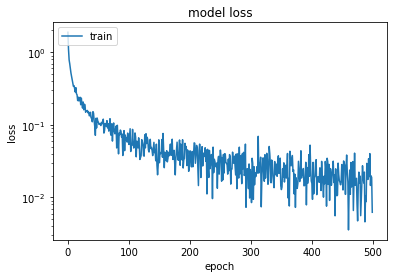

In [5]:
loss_ges = np.append(loss_ges, history.history['loss'])
plt.semilogy(history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Check the model by hand

* The following code uses the trained model to check the deviation for each picture.
* x-axis walks through each pixel, y-axis shows the result

### Check each image for expected and deviation
* setting the switch "only_deviation = true" will only print the images for which the classification and the CNN-result deviates

The output contains the following information:

| Filename      | Expected Category           | Predicted Category        |
|------------- |:-----------------------------:|--------------|
| ziffer_sortiert_resize_NaN/5\Ziffer_4_0034.jpg | 4  | -1 |


ziffer_sortiert_resize\0_1_ht5_20210627-220703.jpg 0 1


ziffer_sortiert_resize\2_10_dig6_20210726-190157.jpg 2 -1


ziffer_sortiert_resize\2_10_dig6_20210727-130728.jpg 2 -1


ziffer_sortiert_resize\2_2_ht7_20210628-083501.jpg 2 -1


ziffer_sortiert_resize\2_4_nt7_20210625-205647.jpg 2 -1


ziffer_sortiert_resize\2_4_nt7_20210625-210138.jpg 2 -1


ziffer_sortiert_resize\3_1_ht4_20210627-124615.jpg 3 -1


ziffer_sortiert_resize\4_10_dig4_20210709-181251.jpg 4 -1


ziffer_sortiert_resize\4_10_ht6_20210703-070449.jpg 4 -1


ziffer_sortiert_resize\4_4_dig6_20210724-184309.jpg 4 -1


ziffer_sortiert_resize\6_3_dig4_20210722-224727.jpg 6 1


ziffer_sortiert_resize\7_10_dig6_20210727-150532.jpg 7 -1


ziffer_sortiert_resize\8_3_dig4_20210725-094630.jpg 8 1


ziffer_sortiert_resize\8_3_dig6_20210716-214753.jpg 8 1


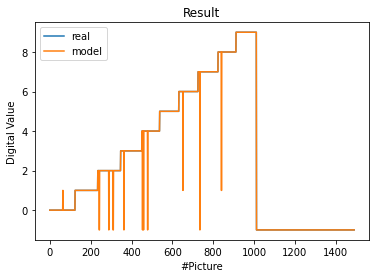

In [6]:
Input_dir='ziffer_sortiert_resize'
res = []
only_deviation = True
show_wrong_image = True

files = glob.glob(Input_dir + '/*.jpg')

for aktfile in files:
    base = os.path.basename(aktfile)
    target = base[0:1]
    if target == "N":
        zw1 = -1
    else:
        zw1 = int(target)
    expected_class = zw1
    image_in = Image.open(aktfile)
    test_image = np.array(image_in, dtype="float32")
    img = np.reshape(test_image,[1,32,20,3])
    classes = np.argmax(model.predict(img), axis=-1)
    classes = classes[0]
    if classes == 10: 
        classes = -1
    zw2 = classes
    zw3 = zw2 - zw1
    res.append(np.array([zw1, zw2, zw3]))
    if only_deviation == True:
        if str(classes) != str(expected_class):
            print(aktfile + " " + str(expected_class) +  " " + str(classes))
            if show_wrong_image == True:
                display(image_in)
    else:
        print(aktfile + " " + aktsubdir +  " " + str(classes))
        

res = np.asarray(res)


plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Digital Value')
plt.xlabel('#Picture')
plt.legend(['real','model'], loc='upper left')
plt.show()

### Save the model

* Save the model to the file with the "h5" file format

In [7]:
FileName = TFliteNamingAndVersion

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(FileName + ".tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpnsg5kbp6\assets


1303008

In [8]:
FileName = TFliteNamingAndVersion + "q.tflite"

import tensorflow as tf

def representative_dataset():
    for n in range(x_data[0].size):
      data = np.expand_dims(x_data[5], axis=0)
      yield [data.astype(np.float32)]
        
converter2 = tf.lite.TFLiteConverter.from_keras_model(model)
converter2.representative_dataset = representative_dataset
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
converter2.representative_dataset = representative_dataset
tflite_quant_model = converter2.convert()

open(FileName, "wb").write(tflite_quant_model)
print(FileName)
Path(FileName).stat().st_size

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpyqjdw3k6\assets


INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpyqjdw3k6\assets


dig1210s1q.tflite


338112

Checking the images shows, that this are border line images, which can be interpreted as a good digit or a faulty one.